# This file demonstrates prediction results from model (DEMO)
- Note this is predictions made purely from a pre-trained model
  - For predictions made form a model trained on our dataset, refer to TrainingModel_Results.ipynb

---



# Mount Drive and import Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 9.0 MB/s eta 0:00:00


In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

import stardist

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

from skimage import io
import os

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input

import pandas as pd
import json

np.random.seed(6)
lbl_cmap = random_label_cmap()

# Data
load images from the sub-folder `train` that have not been used during training.

In [5]:
image_paths = sorted(glob('/content/drive/MyDrive/Grain Boundary Detection/Stardist/data/mydata/train/images/*.tif'))

# Read the images and masks into arrays
X = [io.imread(image_path) for image_path in image_paths]

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [6]:
# show all test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Give Configuration specs here for the model

In [58]:
from stardist.models import Config2D

n_rays = 126

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (1,1)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_shape_completion  = False,
    train_learning_rate = 0.003,
    train_background_reg = 0.00001,
    train_patch_size = (126, 126),
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=127, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=126, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(126, 126), train_background_reg=1e-05, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 127,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 126,
 'grid': (1, 1),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (126, 126),
 'train_background_reg': 1e-05,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.003,


# Load our own pretrained model
- Unzipped and stored in folder 'mymodel'

In [56]:
import zipfile
import json

# Path to the zip file and the extraction directory
zip_file_path = '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/ModelTraining/SavedModel.zip'
extraction_path = '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/ModelTraining'

# Unzip the model folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Define the base directory where the model is unzipped
model_base_dir = os.path.join(extraction_path)

model_dir = '/content/drive/Shared drives/Grain Detection Project Trello/Stardist/ModelTraining'

In [63]:
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    #Load the saved model
    # model = StarDist2D(config=conf, name='SavedModel', basedir=model_dir)

 None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '2D_demo' for 'StarDist2D'.
5298331/5298331 [==============================] - 2s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [64]:
img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

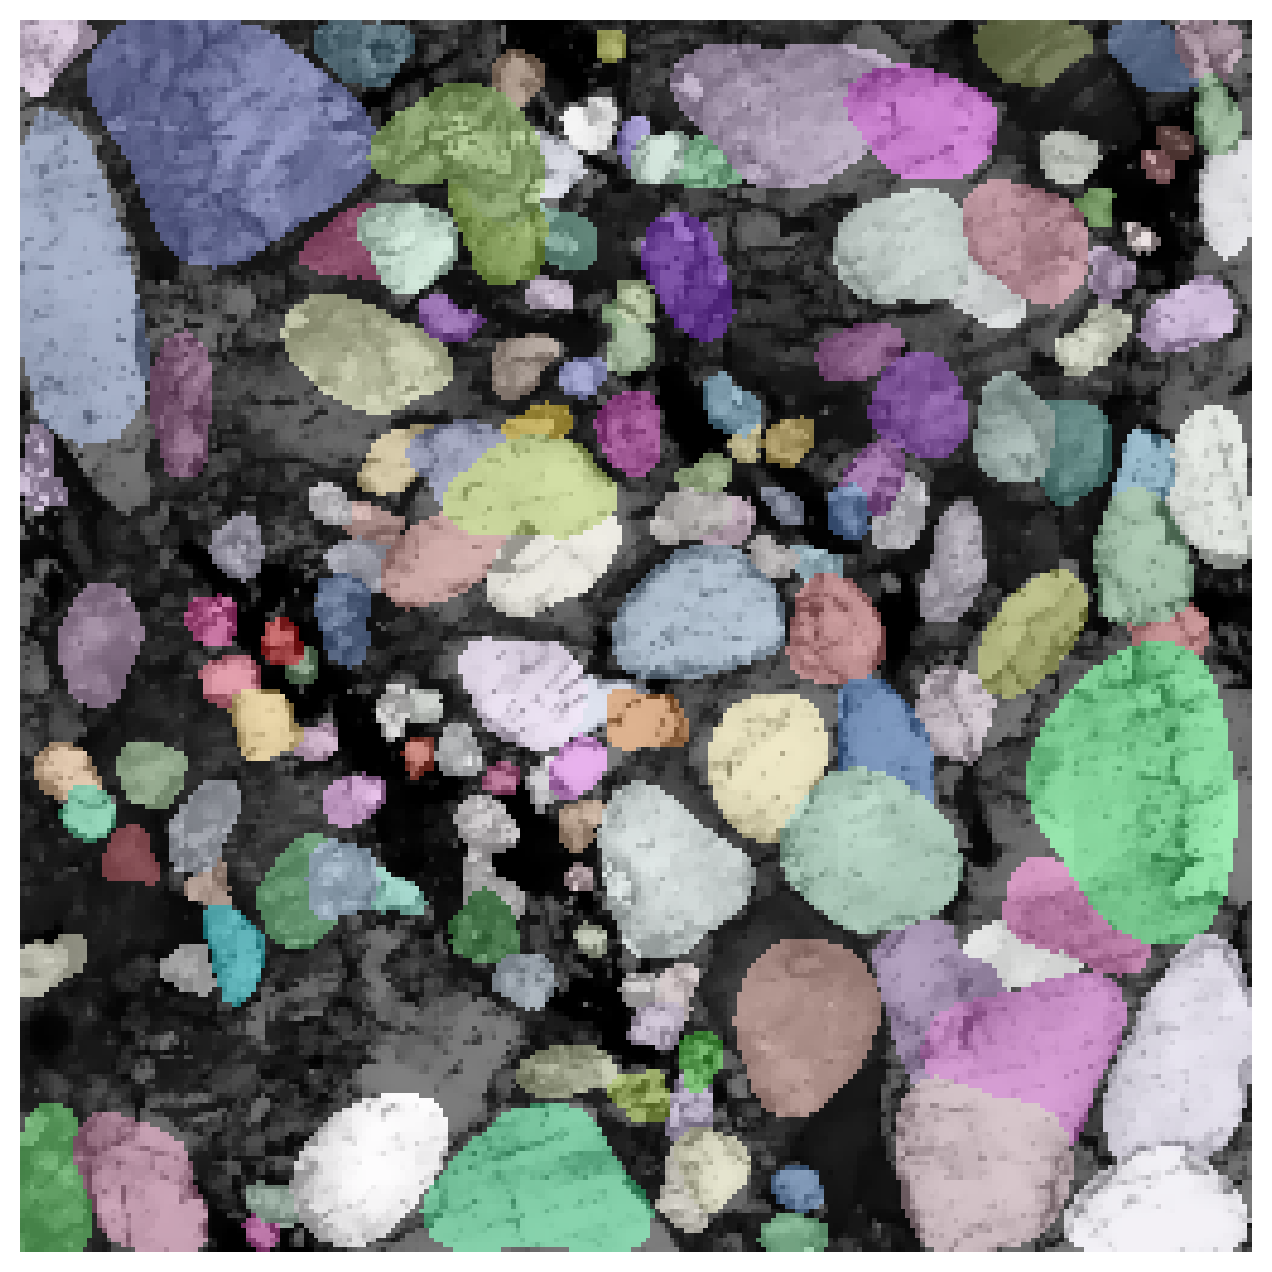

In [65]:
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predictions to disk.  

In [66]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')
# export_imagej_rois('example_rois.zip', details['coord'])

# Example results

In [67]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

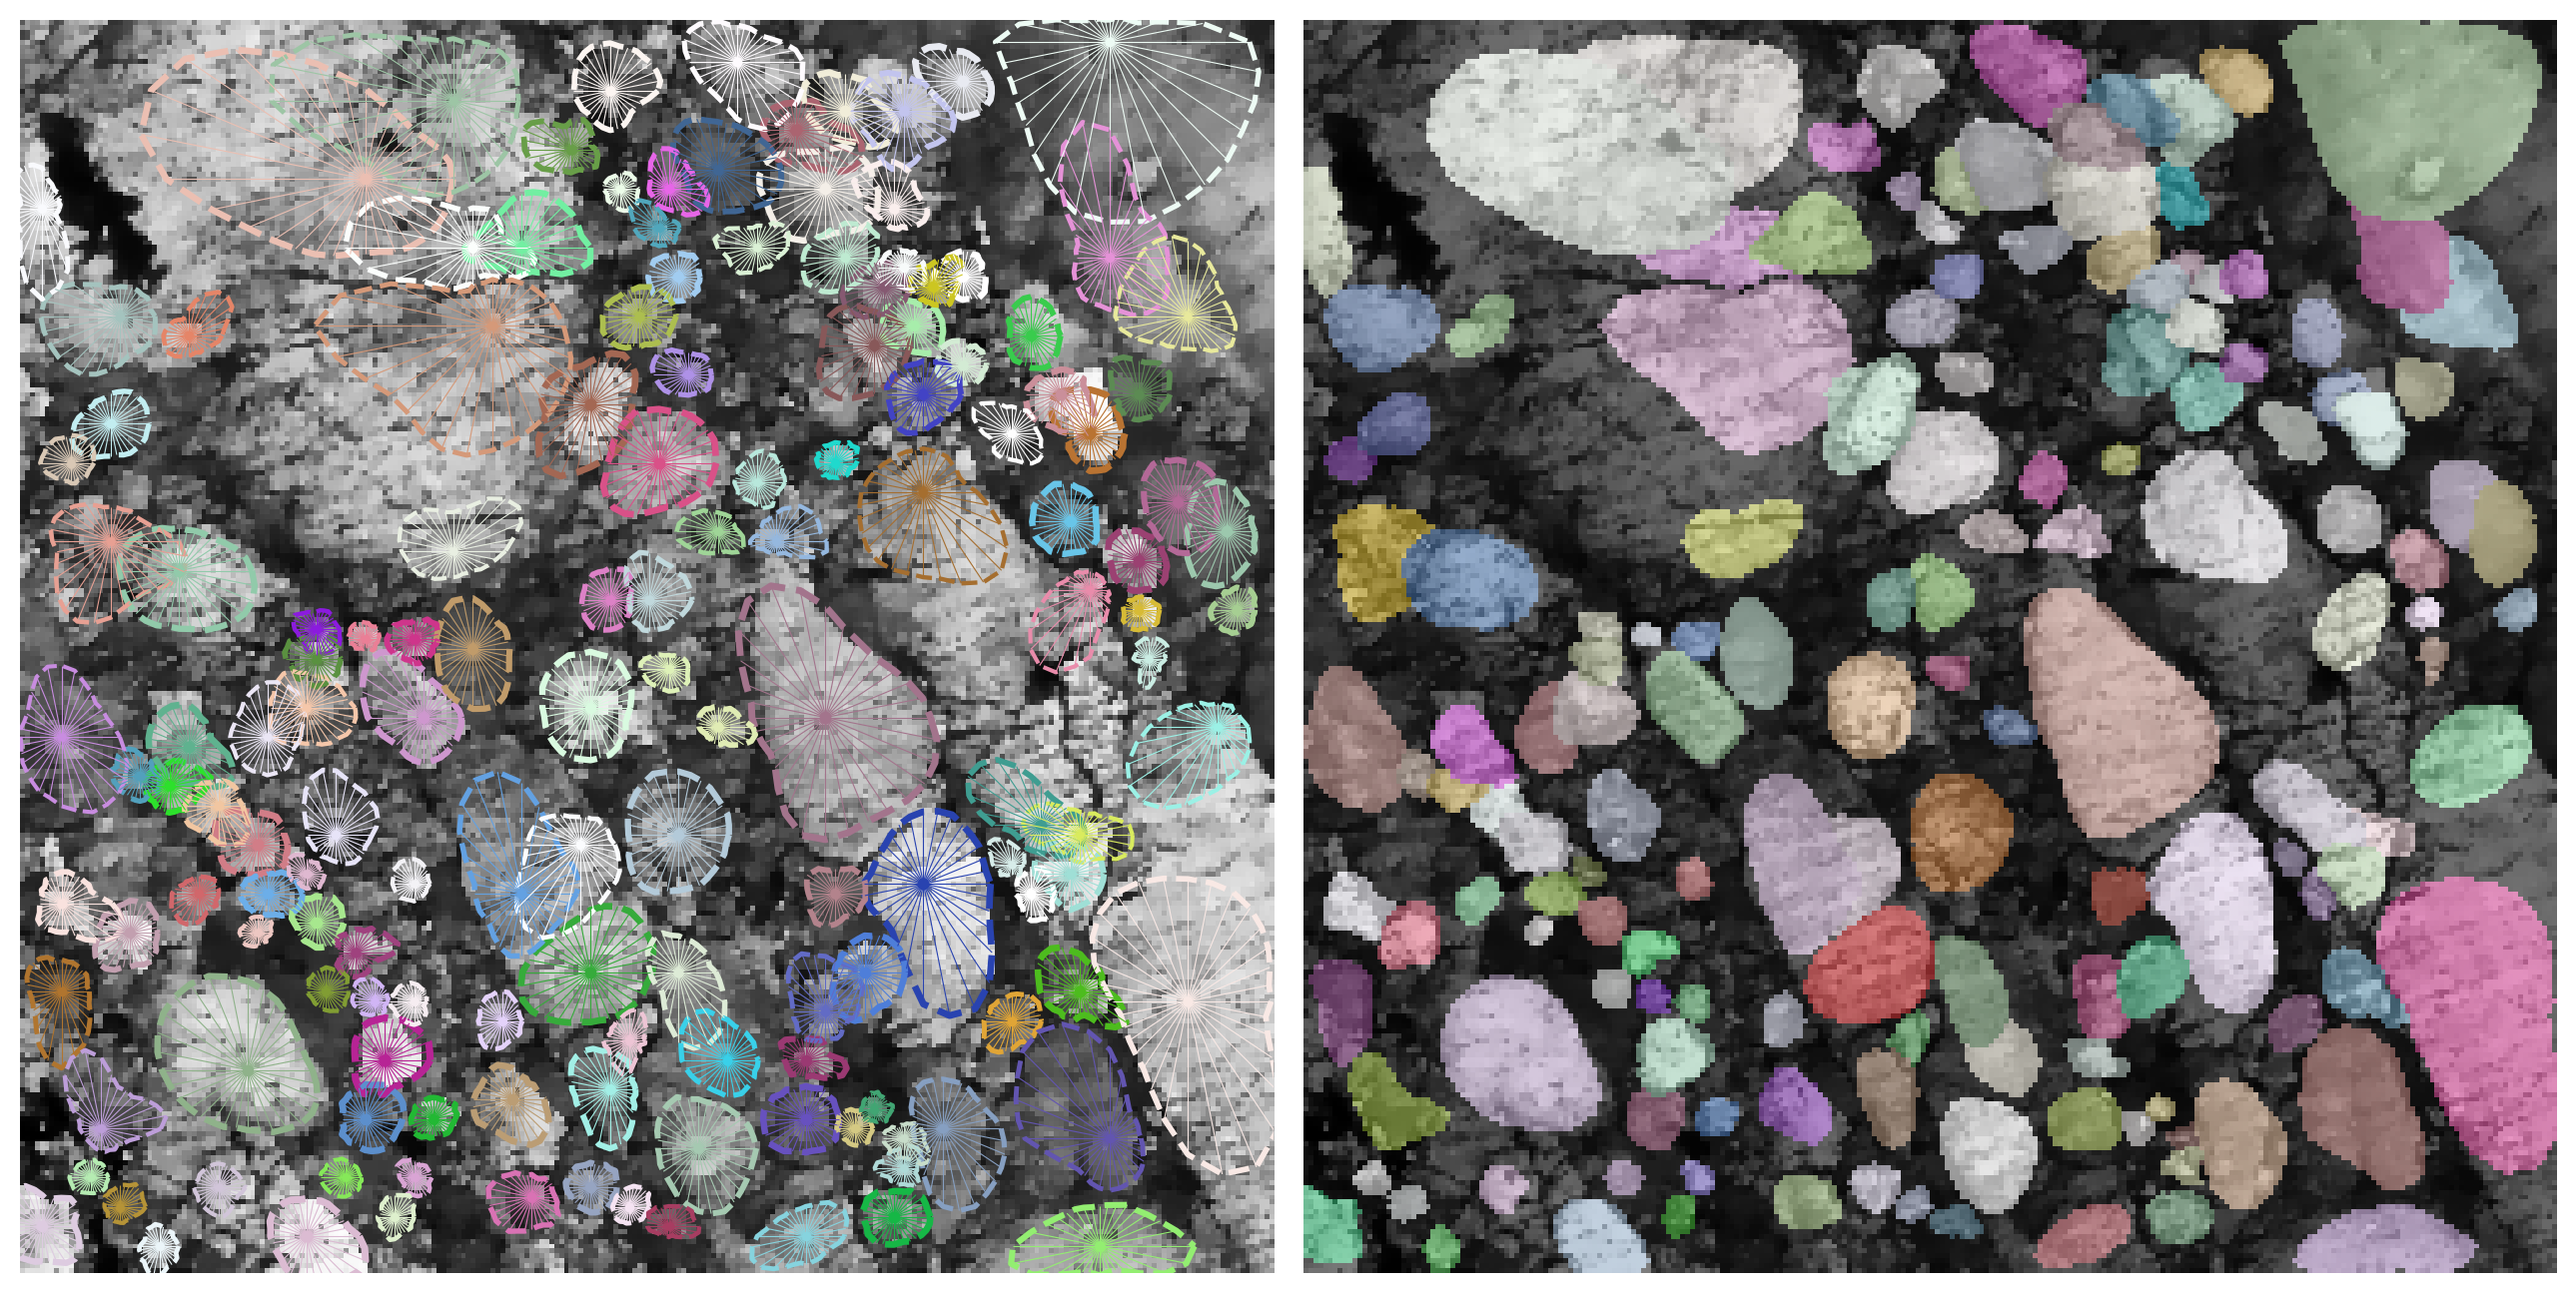

In [68]:
example(model, 42)

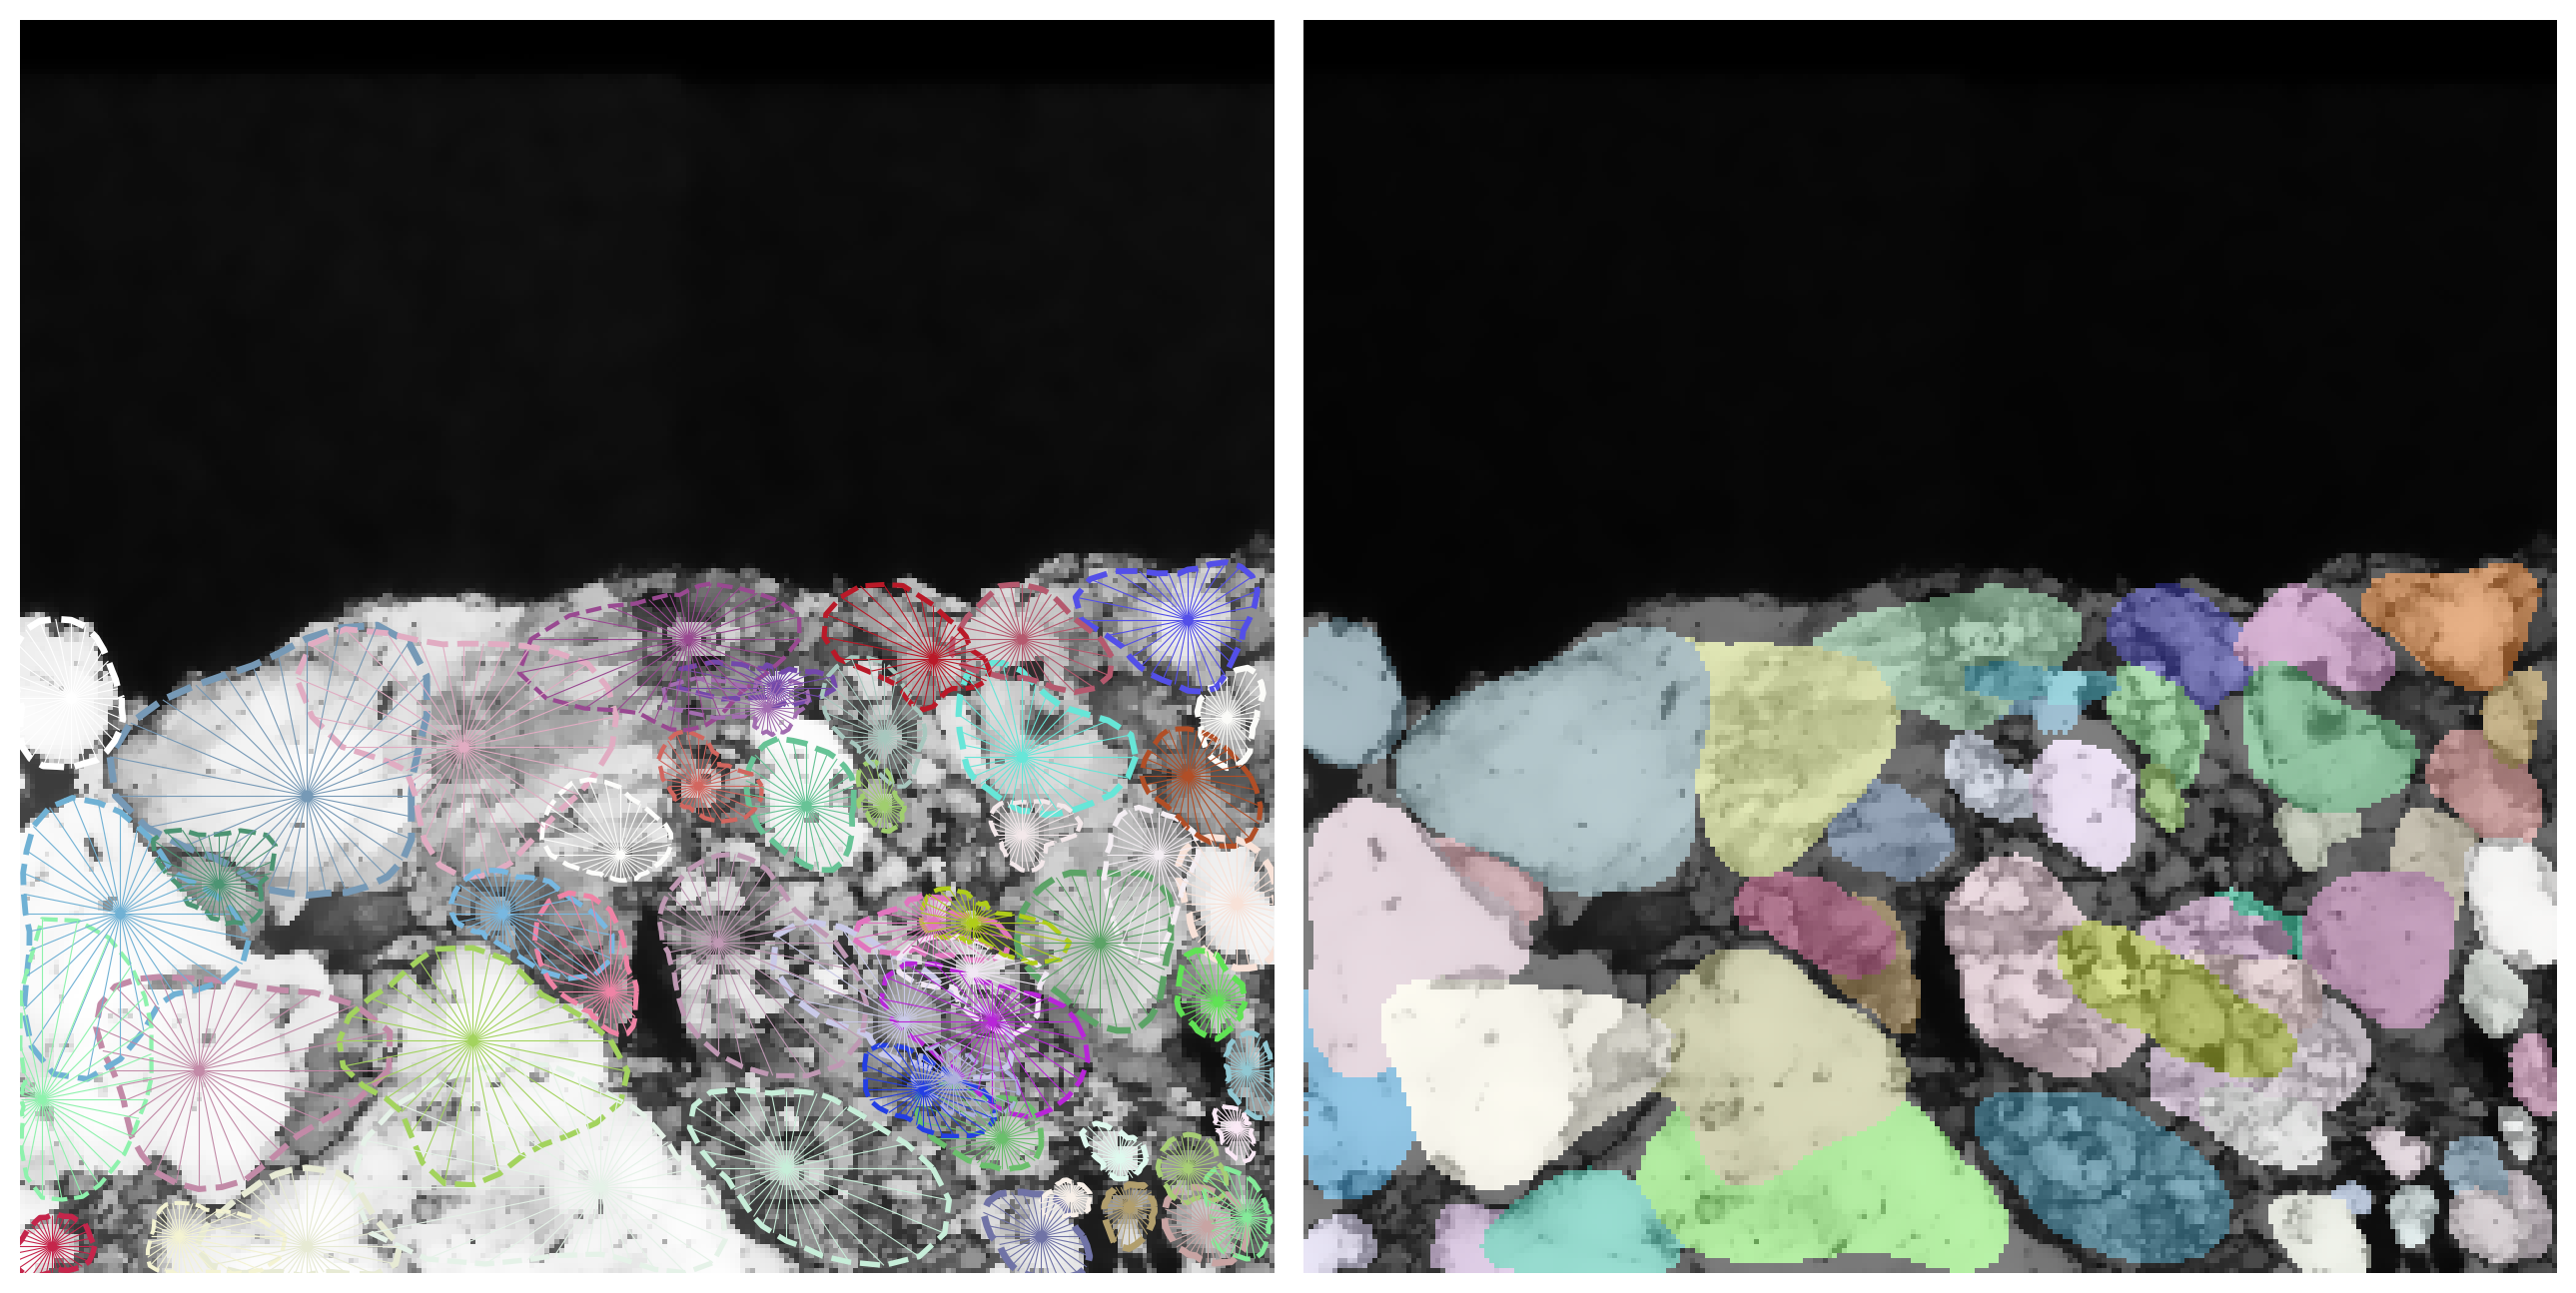

In [69]:
example(model, 1)

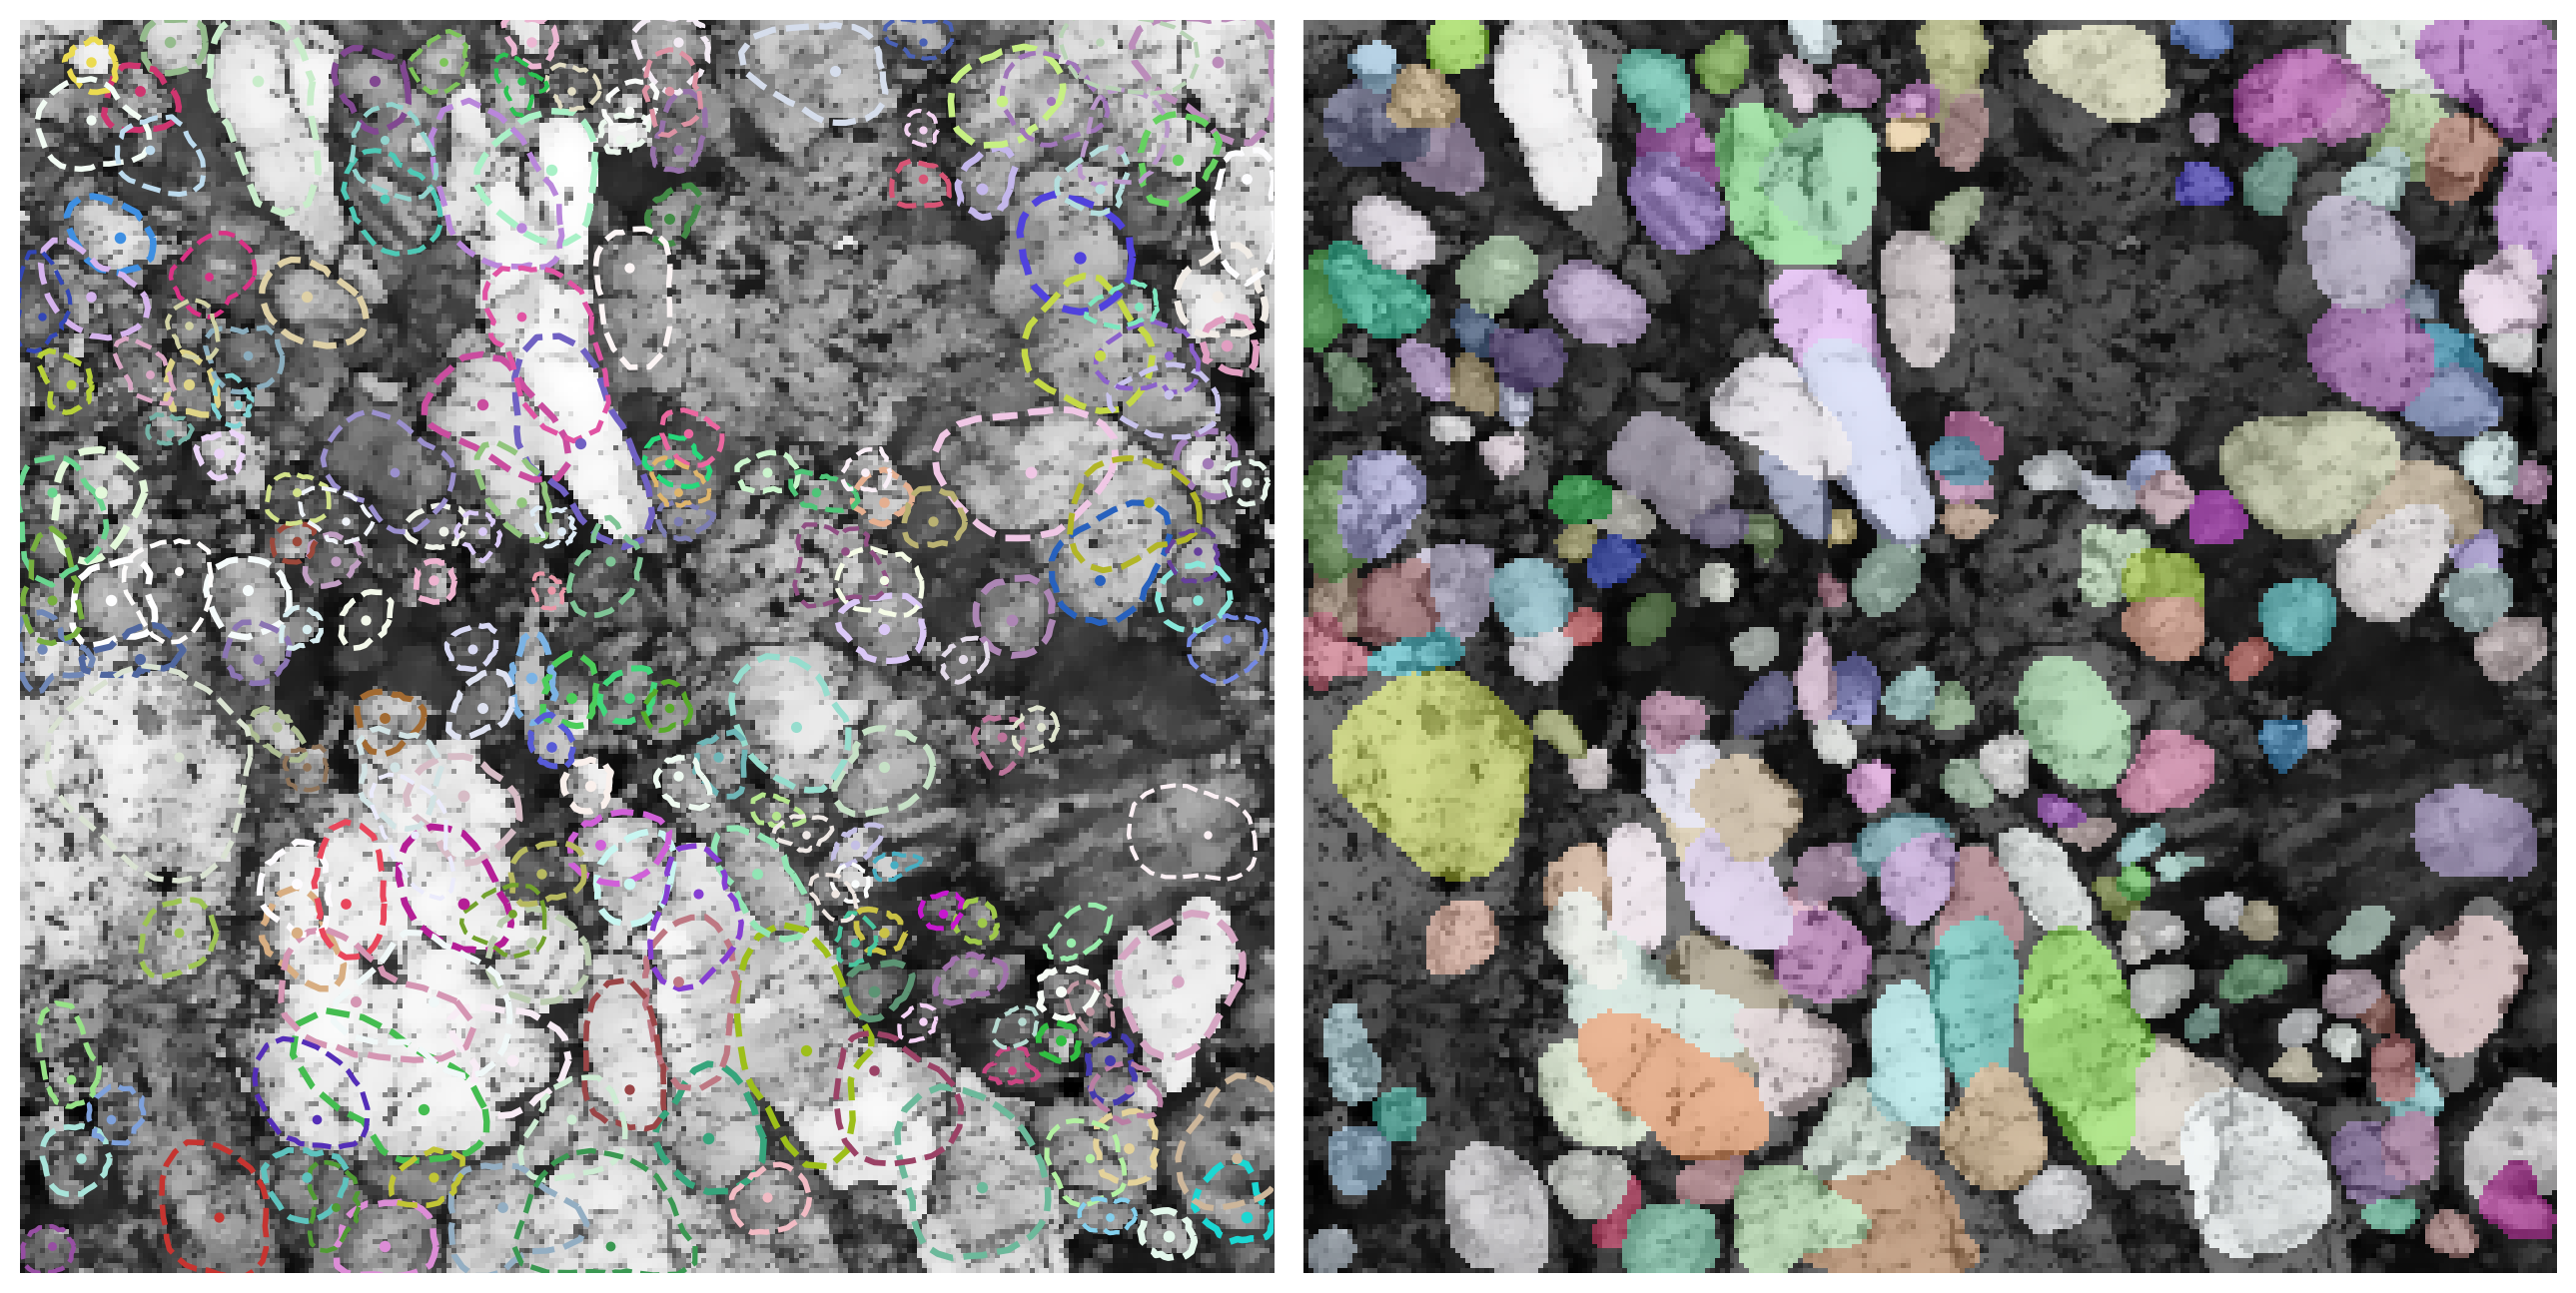

In [70]:
example(model, 15, False)